# Natural Computing - Project
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

The code below uses the DEAP framework (https://github.com/deap/deap), which is a very intuitive framework for evolutionary algorithms and genetic programming.

## Installing required packages

In [1]:
# !pip install deap
# !pip install tensorflow
# !pip install scikit-image

## Imports

In [2]:
from deap import gp, base, tools, creator, algorithms
from tensorflow.keras.datasets import mnist
from skimage.transform import rescale
import matplotlib.pyplot as plt
from functools import partial
from operator import attrgetter
import numpy as np
import random
import math

%matplotlib inline

## Global parameters

In [3]:
# Dataset parameters
STANDARD_IMAGE_SIZE = 28
DESIRED_IMAGE_SIZE = 16
N_CLASSES_TO_USE = 4

# Individual tree parameters
MAX_ARITY = 10
MIN_INITIAL_DEPTH = 3
MAX_INITIAL_DEPTH = 5

# Fitness parameters
N_SAMPLES_TO_TEST = 50

# Evolution parameters
N_GENERATIONS = 100
POPULATION_SIZE = 100

CONTROL_BLOAT = True

TOURNAMENT_SIZE = 10
P_SMALLER_WINS = 0.65

P_CROSSOVER = 1.0
P_CROSSOVER_PER_TREE = 1.0

P_MUTATION = 0.3
P_MUTATION_PER_TREE = 0.2
MIN_MUTATION_DEPTH = 1
MAX_MUTATION_DEPTH = 2

In [4]:
# Parameters that depend on other parameters
RESCALE_FACTOR = DESIRED_IMAGE_SIZE/STANDARD_IMAGE_SIZE
N_PIXELS = DESIRED_IMAGE_SIZE**2

## Loading & preprocessing data

##### Downloading

In [5]:
# Loading the data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

##### Removing classes

In [6]:
# Ensure correct number of classes
X_train = X_train[Y_train < N_CLASSES_TO_USE]
Y_train = Y_train[Y_train < N_CLASSES_TO_USE]
X_test = X_test[Y_test < N_CLASSES_TO_USE]
Y_test = Y_test[Y_test < N_CLASSES_TO_USE]

In [7]:
# Extract and print the number of training and testing samples remaining
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
print(f"Training samples remaining: {n_samples_train}")
print(f"Testing samples remaining: {n_samples_test}")

Training samples remaining: 24754
Testing samples remaining: 4157


##### Rescaling

In [8]:
# Rescaling to the desired size
def rescale_images(images, do_anti_aliasing=False):
    return np.array([rescale(image, RESCALE_FACTOR, anti_aliasing=do_anti_aliasing) for image in images])

# Rescale X_train and X_test
X_train_small = rescale_images(X_train)
X_test_small = rescale_images(X_test)

##### Normalization

In [9]:
# Normalize the data
def normalize(images):
    return (images - np.mean(images, axis=0))/(np.std(images, axis=0) + 0.000001)

# Normalize X_train_small and X_test_small
X_train_norm = normalize(X_train_small)
X_test_norm = normalize(X_test_small)

##### Visualizing the process

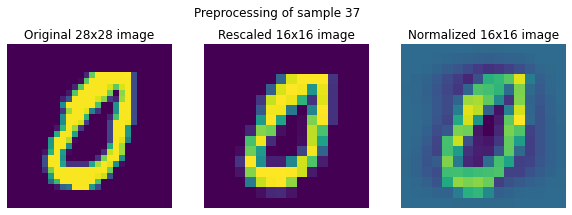

In [10]:
# Plot original and reshaped image
def plot_comparison(idx_to_plot, lists, titles):
    n_plots = len(lists)
    fig, ax = plt.subplots(1,n_plots, figsize=(10,10/n_plots))
    for i in range(n_plots):
        ax[i].imshow(lists[i][idx_to_plot])
        ax[i].set_title(titles[i])
        ax[i].axis("off")
    fig.suptitle(f"Preprocessing of sample {idx_to_plot}",y=1)
    plt.show()
    
plot_comparison(37,
                [X_train, X_train_small, X_train_norm],
                [f"Original {STANDARD_IMAGE_SIZE}x{STANDARD_IMAGE_SIZE} image",
                 f"Rescaled {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image",
                 f"Normalized {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image"])

In [11]:
# Replace and reshape X_train and X_test, for convenience
X_train = X_train_norm.reshape(n_samples_train, DESIRED_IMAGE_SIZE**2)
X_test = X_test_norm.reshape(n_samples_test, DESIRED_IMAGE_SIZE**2)

## Defining operators

In [12]:
# Create set of functions and terminals, with one terminal for each pixel
pset = gp.PrimitiveSet("main", DESIRED_IMAGE_SIZE**2)

In [13]:
# Define operators (with a variable number of inputs)
def linear(*args):
    return sum(args)

def inverse(*args):
    return -sum(args)

def tanh(*args):
    return math.tanh(sum(args))

def sigmoid(*args):
    return 1.0/(1.0 + math.exp(-sum(args)))

def step(*args):
    return float(sum(args) >= 0)

def sine(*args):
    return math.sin(sum(args))

def cosine(*args):
    return math.cos(sum(args))

def gaussian(*args):
    return 0.5*sum(args)*(1.0+math.tanh(math.sqrt(2.0/math.pi)*(sum(args) + 0.044715*sum(args)**3)))
                          
def absolute(*args):
    return abs(sum(args))

In [14]:
# Add operators to the set (using a "hacky" solution to allow variable arities)
for arity in range(1, MAX_ARITY+1):
    pset.addPrimitive(linear, arity)
    pset.addPrimitive(inverse, arity)
    pset.addPrimitive(tanh, arity)
    pset.addPrimitive(sigmoid, arity)
    pset.addPrimitive(step, arity)
    pset.addPrimitive(sine, arity)
    pset.addPrimitive(cosine, arity)
    pset.addPrimitive(gaussian, arity)
    pset.addPrimitive(absolute, arity)

## Defining individuals

In [15]:
# Intialize the toolbox which will contain all sorts of functions for the genetic programming process
toolbox = base.Toolbox()

In [16]:
# Define how to create a random expression/tree (using half-and-half intialization)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_INITIAL_DEPTH, max_=MAX_INITIAL_DEPTH)

In [17]:
# Define classes for fitness, trees and individuals (using DEAP's creator module)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Tree", gp.PrimitiveTree)
creator.create("Individual", list, fitness=creator.FitnessMin)

In [18]:
# Define how to initialize a tree, individual or population
toolbox.register("tree", tools.initIterate, creator.Tree, toolbox.expr)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.tree, N_CLASSES_TO_USE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [19]:
test_pop = toolbox.population(POPULATION_SIZE)

## Fitness function

In [20]:
# Define how to compile a single tree and an individual
toolbox.register("compile_tree", gp.compile, pset=pset)
toolbox.register("compile_individual", lambda individual: [toolbox.compile_tree(t) for t in individual])

In [21]:
# Define fitness function
def fitness(individual, n_samples_to_test):
    # Compile the functions corresponding to the individual
    funcs = toolbox.compile_individual(individual)
    
    # Define how to compute softmax and cross-entropy
    def _softmax(x):
        return np.exp(x)/np.sum(np.exp(x), axis=0)
    def _cross_entropy(pred, label):
        return -np.log(np.exp(pred[label])/np.sum(np.exp(pred), axis=0))
    
    # Create a list of samples to test, ensuring an equal number of samples from each class
    sample_indices = []
    n_samples_per_class = int(n_samples_to_test/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= n_samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:n_samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    losses = []
    for i in sample_indices:
        X_sample, Y_sample = X_train[i], Y_train[i]
        output = _softmax([f(*X_sample) for f in funcs])
        losses.append(_cross_entropy(output, Y_sample))
    
    # Return the average cross-entropy loss
    return (np.average(losses),)

In [22]:
# Add the fitness function to the toolbox
toolbox.register("evaluate", fitness, n_samples_to_test=N_SAMPLES_TO_TEST)

## Evolution components

##### Parent selection

In [23]:
# Redefine the tools.selDoubleTournament function for our multi-tree individuals

# Note: all comments from the original function have been removed to aid readability; the function remains unchanged 
# except for the usage of _size instead of len (as well as some differences in imports and version differences)
def selDoubleTournament(individuals, k, fitness_size, parsimony_size, fitness_first, fit_attr="fitness"):
    assert (1 <= parsimony_size <= 2), "Parsimony tournament size has to be in the range [1, 2]."

    def _sizeTournament(individuals, k, select):
        chosen = []
        for i in range(k):
            prob = parsimony_size / 2.
            ind1, ind2 = select(individuals, k=2)

            # This is the part that matters for our re-implementation: we use the combined length of
            # all trees instead of the length of the individual, which is equal for all individuals
            def _size(individual):
                return sum([len(tree) for tree in individual])
                
            if _size(ind1) > _size(ind2):
                ind1, ind2 = ind2, ind1
            elif _size(ind1) == _size(ind2):
                prob = 0.5

            chosen.append(ind1 if random.random() < prob else ind2)

        return chosen

    def _fitTournament(individuals, k, select):
        chosen = []
        for i in range(k):
            aspirants = select(individuals, k=fitness_size)
            chosen.append(max(aspirants, key=attrgetter(fit_attr)))
        return chosen

    if fitness_first:
        tfit = partial(_fitTournament, select=tools.selRandom)
        return _sizeTournament(individuals, k, tfit)
    else:
        tsize = partial(_sizeTournament, select=tools.selRandom)
        return _fitTournament(individuals, k, tsize)

In [24]:
# Define how to select parents (tournament selection; either controlling for bloat or not controlling for it)
if CONTROL_BLOAT:
    toolbox.register("select", 
                     selDoubleTournament, 
                     fitness_size=TOURNAMENT_SIZE, 
                     parsimony_size=P_SMALLER_WINS*2, 
                     fitness_first=False)
else:
    toolbox.register("select", 
                     tools.selTournament, 
                     tournsize=TOURNAMENT_SIZE)

##### Crossover

In [25]:
# Define how to perform crossover
def crossover(ind1, ind2):
    new_ind1, new_ind2 = [], []
    for i in range(N_CLASSES_TO_USE):
        tree1, tree2 = ind1[i], ind2[i]
        if np.random.random() < P_CROSSOVER_PER_TREE:
            tree1, tree2 = gp.cxOnePoint(tree1, tree2)
        new_ind1.append(tree1)
        new_ind2.append(tree2)
    return (creator.Individual(new_ind1), creator.Individual(new_ind2))

In [26]:
# Add the crossover ("mate") function to the toolbox
toolbox.register("mate", crossover)

##### Mutation

In [27]:
# Define how to create a "mutation tree"
toolbox.register("expr_mut", gp.genHalfAndHalf, min_=MIN_MUTATION_DEPTH, max_=MAX_MUTATION_DEPTH)

In [28]:
# Define how to perform mutation
def mutate(individual):
    new_ind = []
    for tree in individual:
        if np.random.random() < P_MUTATION_PER_TREE:
            new_ind.append(gp.mutUniform(tree, expr=toolbox.expr_mut, pset=pset)[0])
        else:
            new_ind.append(tree)
    return creator.Individual(new_ind),

In [29]:
# Add the mutation ("mutate") function to the toolbox
toolbox.register("mutate", mutate)

##### Height boundary

## Statistics

In [30]:
# OLD!
# Functions for determining average, min and max, which control for the possibility that the input might consist of tuples
def tuple_avg(a):
    if len(a[0]) == 2:
        return np.mean([x[0] for x in a])
    return np.mean(a)

def tuple_min(a):
    if len(a[0]) == 2:
        return np.min([x[0] for x in a])
    return np.min(a)

def tuple_max(a):
    if len(a[0]) == 2:
        return np.max([x[0] for x in a])
    return np.max(a)

# Function for determining the size of the agent with the best fitness
def tuple_best_size(a):
    if len(a[0]) == 2:
        return np.amax(a, 1)[0]
    return None

In [31]:
# OLD!
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
#stats_size = tools.Statistics(lambda ind: [len(ind), ind.fitness.values[0]])
mstats = tools.MultiStatistics(fitness=stats_fit)#, size=stats_size)
mstats.register("avg",  tuple_avg)
mstats.register("min",  tuple_min)
mstats.register("max",  tuple_max)
#mstats.register("best", tuple_best_size)

## Running the genetic programming algorithm

In [32]:
# OLD!
pop = toolbox.population(POPULATION_SIZE)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(population=pop, 
                               toolbox=toolbox, 
                               cxpb=P_CROSSOVER, 
                               mutpb=P_MUTATION, 
                               ngen=N_GENERATIONS, 
                               stats=mstats, 
                               halloffame=hof, 
                               verbose=True)

   	      	               fitness                
   	      	--------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals
0  	100   	1.44311	0  	1.60561	1.32011	100   
1  	100   	1.38085	1  	1.54238	1.30531	100   
2  	100   	1.36487	2  	1.42794	1.30834	100   
3  	100   	1.36582	3  	1.46671	1.2484 	100   
4  	100   	1.36283	4  	1.45758	1.30143	100   
5  	100   	1.3679 	5  	1.47912	1.28369	100   
6  	100   	1.36376	6  	1.47892	1.23708	100   
7  	100   	1.36431	7  	1.45963	1.2733 	100   
8  	100   	1.345  	8  	1.4816 	1.22923	100   
9  	100   	1.34373	9  	1.47859	1.22876	100   
10 	100   	1.33733	10 	1.51785	1.20108	100   
11 	100   	1.32316	11 	1.44306	1.21836	100   
12 	100   	1.32625	12 	1.43489	1.21768	100   
13 	100   	1.31113	13 	1.45951	1.22434	100   


<ipython-input-21-cd3d11961881>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(x)/np.sum(np.exp(x), axis=0)
<ipython-input-21-cd3d11961881>:8: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(x)/np.sum(np.exp(x), axis=0)


14 	100   	nan    	14 	nan    	nan    	100   
15 	100   	1.3104 	15 	1.44548	1.19429	100   
16 	100   	1.29111	16 	1.43593	1.17273	100   
17 	100   	1.29369	17 	1.40902	1.18139	100   
18 	100   	1.28688	18 	1.41502	1.18006	100   
19 	100   	1.27862	19 	1.38276	1.15193	100   
20 	100   	1.28006	20 	1.41307	1.1554 	100   
21 	100   	1.26816	21 	1.39264	1.15416	100   
22 	100   	1.25758	22 	1.40808	1.14071	100   
23 	100   	1.26022	23 	1.40483	1.15408	100   
24 	100   	1.25099	24 	1.38231	1.12102	100   
25 	100   	1.25859	25 	1.37021	1.14277	100   
26 	100   	1.24795	26 	1.35526	1.13514	100   
27 	100   	1.24647	27 	1.43301	1.16105	100   
28 	100   	1.24056	28 	1.36018	1.12083	100   
29 	100   	1.22759	29 	1.35679	1.11655	100   
30 	100   	1.2385 	30 	1.46695	1.10066	100   
31 	100   	1.23182	31 	1.36678	1.13334	100   
32 	100   	1.23152	32 	1.33976	1.14287	100   
33 	100   	1.2272 	33 	1.3784 	1.11389	100   
34 	100   	1.21737	34 	1.3362 	1.10882	100   
35 	100   	1.22052	35 	1.35688	1.0

In [33]:
for t in hof[0]:
    print(t)
    print("")

linear(ARG115, ARG140, step(ARG107, ARG192), absolute(ARG45, absolute(ARG131), step(ARG85), sine(ARG226, ARG81, ARG219, ARG99, ARG118, inverse(ARG0, ARG81, ARG94, ARG226)), cosine(ARG125, ARG241, ARG101, ARG117, ARG115), ARG146, sigmoid(ARG251, ARG93, ARG123, ARG125), cosine(ARG196, ARG67), tanh(ARG156, ARG0, ARG130, ARG149, ARG143)), gaussian(absolute(linear(sigmoid(ARG18, ARG251), step(cosine(ARG71, ARG180, ARG191, ARG36, ARG179, ARG84, ARG50, sine(ARG251, ARG81, ARG219, ARG99, ARG118, ARG252), ARG18, ARG18), ARG148, ARG231, ARG243, ARG67, ARG85, step(ARG39, ARG142, ARG241, ARG225, ARG123, ARG237, ARG219, ARG23, ARG232)), ARG236, ARG230, ARG77, ARG107, step(ARG51, ARG84))), gaussian(ARG114, ARG20, ARG251, ARG221, ARG107, ARG156), sine(ARG226, ARG81, ARG72, ARG99, ARG118, inverse(ARG0, ARG81, ARG94, ARG226)), cosine(ARG67, ARG191, ARG232, ARG131, ARG155), step(ARG107, ARG192), cosine(ARG194, inverse(ARG0, ARG252, ARG94, ARG226), ARG107, ARG82, ARG145, ARG95, ARG29, ARG191, ARG126), AR

In [34]:
funcs = toolbox.compile_individual(hof[0])
n_correct = 0
for i in range(n_samples_train):
    out = [f(*X_train[i]) for f in funcs]
    n_correct += np.argmax(out) == Y_train[i]
print(n_correct/n_samples_train)

0.5915003635776036


In [35]:
funcs = toolbox.compile_individual(hof[0])
n_correct = 0
for i in range(n_samples_test):
    out = [f(*X_test[i]) for f in funcs]
    n_correct += np.argmax(out) == Y_test[i]
print(n_correct/n_samples_test)

0.5989896560019244


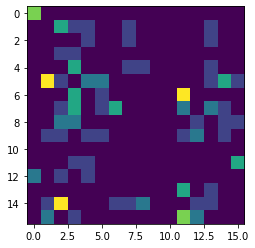

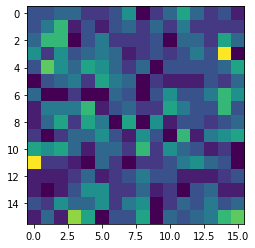

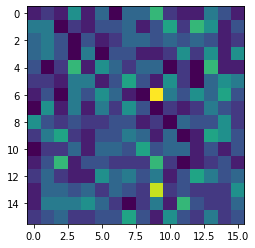

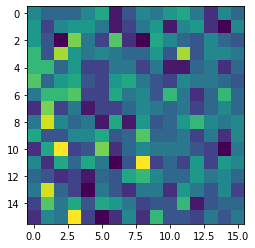

In [36]:
import re
for tree in hof[0]:
    inputs_used = list(map(int, re.findall("[0-9]+", str(tree))))
    input_tallies = np.zeros(DESIRED_IMAGE_SIZE**2)
    for i in inputs_used:
        input_tallies[i] += 1
    plt.imshow(input_tallies.reshape(DESIRED_IMAGE_SIZE, DESIRED_IMAGE_SIZE))
    plt.show()